In [2]:
import os
import glob

import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import utils
from model import BadModel, BadModel2
from dataset import SwingDataset, augment

In [3]:
torch.__version__

'1.7.0'

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/oloff/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
path = "data/"

In [7]:
shot_types = ["Pull-hook", "Hook", "Pull", "Fade", "Straight", "Draw", "Push", "Slice" , "Push-slice"]

In [8]:
X_data, y_data = utils.load_data(path)

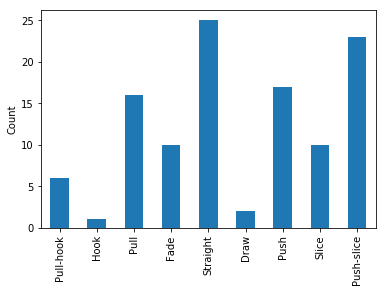

In [9]:
utils.plot_counts(y_data, xticks_label = shot_types)

In [10]:
n = X_data.shape[0]

# GENERATE DATA SPLITS
train = 0.75
val = 0.20
test = 0.05

X_train = X_data[:int(n*train),:,:] 
y_train = y_data[:int(n*train),:]

X_val = X_data[int(n*train):int(n*(val+train)),:,:]
y_val = y_data[int(n*train):int(n*(val+train)),:]

X_test = X_data[-int(n*test):,:,:]
y_test = y_data[-int(n*test):,:]

# /GENERATE DATA SPLITS

In [11]:
X_train.shape, X_val.shape, X_test.shape

((82, 6, 500), (22, 6, 500), (5, 6, 500))

In [12]:
train_set = SwingDataset(X_train, y_train, augment=True, oversample = True)
val_set = SwingDataset(X_val, y_val, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)
test_set = SwingDataset(X_test, y_test, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)

In [13]:
np.save("norm_data/X_mean.npy", train_set.mean)
np.save("norm_data/X_std.npy", train_set.std)
np.save("norm_data/y_mean.npy", train_set.y_dist_mean)
np.save("norm_data/y_std.npy", train_set.y_dist_std)

In [14]:
train_set.mean == np.load("norm_data/X_mean.npy")

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

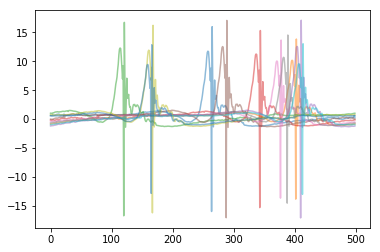

In [15]:
# test the data augmentation
plt.plot(train_set.X_data[0][0],alpha=0.5)
for _ in range(10):
    plt.plot(augment(train_set.X_data[0][0]), alpha=0.5)
plt.show()

In [16]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, drop_last=False, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, drop_last=False, shuffle=True)

In [17]:
bestmodel_file = os.path.join("weights", "best_model.pth")

model = BadModel2().to(device)
# model = MSResNet(input_channel=6, num_classes=10)

swing_type_loss = nn.BCEWithLogitsLoss()
#swing_type_loss = nn.BCELoss()
distance_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

losses = []
va_losses = []
num_epochs = 10
iter_idx = -1
best_va_loss = 9999 
val_interval = 50
report_interval = 10

In [18]:
loss_history = []
epochs = 100
for e in range(epochs):
    prefix = "Epoch {:3d}: ".format(e)
#     for data in tqdm(train_loader, desc=prefix):
    for data in train_loader:
        print(e, end="\r", flush=True)
        iter_idx += 1
        X_train, y = data
        
        X_train = X_train.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_train.float())
#        swing_loss = swing_type_loss(outputs[:, :-1], torch.max(y[:, :-1], 1)[1])
        swing_loss = swing_type_loss(outputs[:, :-1], y[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y[:, -1:])
        loss = swing_loss + dist_loss
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if iter_idx % val_interval == 0:
            va_loss = []
            model = model.eval()
            for data in val_loader:
                X_va, y_va = data
                X_va = X_va.to(device)
                y_va = y_va.to(device)
                with torch.no_grad():
                    outputs_va = model(X_va.float())               
                    swing_loss = swing_type_loss(outputs_va[:, :-1], y_va[:, :-1])
                    dist_loss =  distance_loss(outputs_va[:, -1:], y_va[:, -1:])
                    loss = swing_loss + dist_loss
                    va_loss += [loss.cpu().numpy()]
                    
            model = model.train()
            va_loss = np.mean(va_loss)
            va_losses.append(va_loss)
            
            if va_loss < best_va_loss:
                best_va_loss = va_loss
                torch.save({
                    "iter_idx": iter_idx,
                    "best_va_loss": best_va_loss,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                }, bestmodel_file)

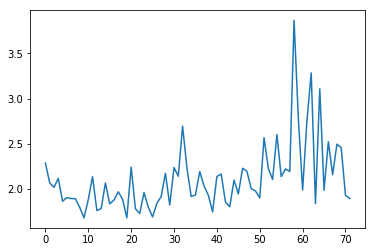

In [19]:
plt.plot(va_losses)

In [20]:
def print_preds(predictions, truth, mean, std):
    for pred, true in zip(predictions, truth):
        pred_distance = pred[-1] * std + mean
        pred_argmax = torch.argmax(pred[:-1])
        pred_shot_type = shot_types[pred_argmax]
        print(f"Pred: {pred_shot_type} {round(pred_distance.item())}yds")
        
        true_distance = true[-1] * std + mean
        true_argmax = torch.argmax(true[:-1])
        true_shot_type = shot_types[true_argmax]
        
        print(f"True: {true_shot_type} {round(true_distance.item())}yds")
        print()

In [21]:
print_preds(outputs, y, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Pull-hook 48yds
True: Slice 10yds

Pred: Hook 108yds
True: Push 90yds

Pred: Draw 116yds
True: Draw 145yds

Pred: Hook 95yds
True: Straight 20yds



In [22]:
print_preds(outputs_va, y_va, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Pull 140yds
True: Pull-hook 140yds

Pred: Draw 123yds
True: Pull 145yds



# Test

In [33]:
# normalization moved to the dataloader
# X_test_norm = norm(X_test, train_mean, train_std)
# y_test_norm = y_test.copy()
# y_test_norm[:, -1] -= y_distance_mean
# y_test_norm[:, -1] /= y_distance_std

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, drop_last=False)

In [34]:
swing_losses, dist_losses, total_losses, = [], [], []
model = model.eval()
idx = 0

test_out = []
true_out = []
test_shot_types = []
true_shot_types = []

with torch.no_grad():
    for data in test_loader:
        idx += 1
        x_test, y_test = data
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        outputs = model(x_test.float())
        
        swing_loss = swing_type_loss(outputs[:, :-1], y_test[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y_test[:, -1:])
        total_loss = swing_loss + dist_loss
        
        swing_losses += [swing_loss.cpu().numpy()]
        dist_losses += [dist_loss.cpu().numpy()]
        total_losses += [total_loss.cpu().numpy()]
        
        print("Test example %d: swing_loss = %f, dist_loss = %f" % (idx, swing_losses[idx-1], dist_losses[idx-1]))
  
        test_out.append(outputs[0])
        true_out.append(y_test[0])
        test_shot_types.append(np.argmax(outputs[:, :-1]).item())
        true_shot_types.append(np.argmax(y_test[:, :-1]).item())
#         test_shot_dist.append(outputs[:,0].item())
#         true_shot_dist.append(y_test[:,0].item())
    
    avg_swing_loss = np.mean(swing_losses)
    avg_dist_loss = np.mean(dist_losses)
    avg_total_loss = np.mean(total_losses)
    print()
    print("Out of %d test examples: avg_swing_loss = %f, avg_dist_loss = %f, avg_total_loss = %f" % (idx, avg_swing_loss, avg_dist_loss, avg_total_loss))

Test example 1: swing_loss = 0.434818, dist_loss = 0.233093
Test example 2: swing_loss = 0.399774, dist_loss = 0.030733
Test example 3: swing_loss = 0.380887, dist_loss = 0.732709
Test example 4: swing_loss = 0.394326, dist_loss = 0.034061
Test example 5: swing_loss = 0.328475, dist_loss = 4.139097

Out of 5 test examples: avg_swing_loss = 0.387656, avg_dist_loss = 1.033939, avg_total_loss = 1.421594


In [35]:
print_preds(test_out, true_out, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Hook 116yds
True: Push 100yds

Pred: Draw 124yds
True: Straight 130yds

Pred: Hook 97yds
True: Straight 125yds

Pred: Draw 124yds
True: Straight 130yds

Pred: Push-slice 76yds
True: Straight 10yds



In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [27]:
cm = confusion_matrix(true_shot_types, test_shot_types)

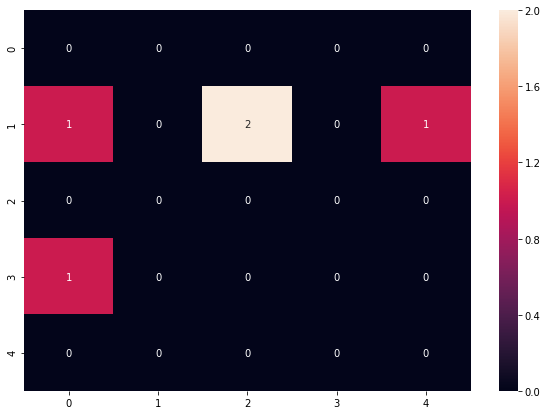

In [28]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

In [29]:
import torch.nn.functional as F

class BadModel2(nn.Module):

    def __init__(self):
        super(BadModel2, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 10, (3, 20), stride=(3, 5))
        self.conv2 = nn.Conv2d(10, 16, (2, 15), stride=(1, 3))

        self.fc1_cls = nn.Linear(16 * 6, 120)  # 6*6 from image dimension
        self.fc2_cls = nn.Linear(120, 84)
        self.fc3_cls = nn.Linear(84, 9)
        
        self.fc1_dist = nn.Linear(16 * 6, 50)
        self.fc2_dist = nn.Linear(50, 1)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (1,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (1,2))
                        
        x = x.view(-1, self.num_flat_features(x))
        
        x_cls = F.relu(self.fc1_cls(x))
        x_cls = F.relu(self.fc2_cls(x_cls))
        x_cls = self.fc3_cls(x_cls)
        x_cls = self.softmax(x_cls)
        
        x_dist = F.relu(self.fc1_dist(x))
        x_dist = self.fc2_dist(x_dist)

        x = torch.cat([x_cls, x_dist], axis=1)
        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [30]:
inputs = torch.rand(4,1,6,500)

In [31]:
m = BadModel2()

In [32]:
m(inputs)

tensor([[ 0.1142,  0.1116,  0.1225,  0.1167,  0.0959,  0.1069,  0.1190,  0.1099,
          0.1031, -0.0112],
        [ 0.1141,  0.1120,  0.1223,  0.1169,  0.0962,  0.1055,  0.1191,  0.1100,
          0.1039, -0.0262],
        [ 0.1141,  0.1118,  0.1216,  0.1168,  0.0961,  0.1067,  0.1189,  0.1103,
          0.1038, -0.0068],
        [ 0.1138,  0.1122,  0.1220,  0.1170,  0.0960,  0.1066,  0.1182,  0.1096,
          0.1047,  0.0008]], grad_fn=<CatBackward>)